In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data analysis and manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

# -----------------------------
# Lineal Models
# -----------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

# -----------------------------
# SVMs
# -----------------------------
from sklearn.svm import SVC, LinearSVC

# -----------------------------
# Decision Tree and ensembles
# -----------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

# -----------------------------
# KNN
# -----------------------------
from sklearn.neighbors import KNeighborsClassifier

# -----------------------------
# Naive Bayes
# -----------------------------
from sklearn.naive_bayes import GaussianNB

# -----------------------------
# Neural Network
# -----------------------------
from sklearn.neural_network import MLPClassifier

# -----------------------------
# External Boosters
# -----------------------------
import xgboost as xgb
import lightgbm as lgb

# Loadind dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# EDA - Titanic Dataset

We begin this project with an Exploratory Data Analysis (EDA) to gain a deeper understanding of the Titanic dataset and the variables it contains. The goal of this step is to identify patterns, relationships, and potential data quality issues that might influence the survival outcome.

By exploring the dataset, we can better understand the characteristics of the passengers and how different factors — such as age, gender, or passenger class — may have affected their chances of survival. This analysis will also be followed by feature engineering, data visualization and modeling.

### Variables Qualitatives:
 
* Nominal: Survived, Sex, Embarked, Name, Ticket, Cabin
* Ordinal: Pclass

### Variables Quantitatives:

   * Continuous: Age, Fare
   * Discrete: SibSp, Parch

In [2]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Featuring Engineering

Before moving on to data visualization and modeling, it’s important to prepare and enrich the dataset to maximize the predictive potential of our models.

In this section, we will handle missing values by filling them with the appropriate statistical measure based on the corresponding variables and we will create several new features derived from the existing ones to capture useful patterns and relationships that may improve model performance.

The goal of this step is to enhance the dataset with more informative and cleaner features, making it easier for the models to learn relevant insights during training.

In [5]:
# Some variables with null data that need to be cleaned or filled in
print(f'Train Nulls:\n\n{train_df.isnull().sum()}\n\nTest Nulls:\n\n{test_df.isnull().sum()}')

Train Nulls:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test Nulls:

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [6]:
# Getting the title from the name using regex and cleaning it
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)

train_df['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'Countess', 'Dona'], 'Miss', inplace=True)
test_df['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'Countess', 'Dona'], 'Miss', inplace=True)

train_df['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer', 'Rev'], 'Mr', inplace=True)
test_df['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer', 'Rev', 'Dr'], 'Mr', inplace=True)

In [7]:
# Given most common embarked place to the null data
most_common = train_df['Embarked'].mode()[0]
train_df['Embarked'] = train_df['Embarked'].fillna(most_common)
test_df['Embarked'] = test_df['Embarked'].fillna(most_common)

In [8]:
def impute_variable(row, variable, values_dict, group_cols=('Pclass','Sex')):
    if pd.isnull(row[variable]):
        key = tuple(row[col] for col in group_cols)
        return values_dict.loc[key]
    else:
        return row[variable]
        
# Given the media fare group by pclass and sex for the pclass to the only null fare in test
fare_median = train_df.groupby(['Pclass','Sex'])['Fare'].mean()
test_df['Fare'] = test_df.apply(impute_variable, axis=1, variable='Fare', values_dict=fare_median)

# Given the median age group by pclass and sex to the null ages
age_median = train_df.groupby(['Pclass','Sex'])['Age'].median()
train_df['Age'] = train_df.apply(impute_variable, axis=1, variable='Age', values_dict=age_median)
test_df['Age'] = test_df.apply(impute_variable, axis=1, variable='Age', values_dict=age_median)

In [9]:
# Creating new combined feature SexClass
train_df['SexClass'] = train_df['Sex'] + '_' + train_df['Pclass'].astype(str)
test_df['SexClass'] = test_df['Sex'] + '_' + test_df['Pclass'].astype(str)

In [10]:
# Dividing ages into categories 
bins = [0, 12, 18, 30, 50, 80]
labels = ['Child','Teen','Young','Adult','Elder']
train_df['AgeCategory'] = pd.cut(train_df['Age'], bins=bins, labels=labels)
test_df['AgeCategory'] = pd.cut(test_df['Age'], bins=bins, labels=labels)

In [11]:
# Creating new variables from Ticket
train_df['TicketLett'] = train_df.Ticket.apply(lambda x: x[:2])
test_df['TicketLett'] = test_df.Ticket.apply(lambda x: x[:2])

train_df['TicketLen'] = train_df.Ticket.apply(lambda x: len(x))
test_df['TicketLen'] = test_df.Ticket.apply(lambda x: len(x))

train_df['TicketNum'] = (train_df['Ticket'].str.extract(r'^.*?(\d*)$').replace('', '0').astype('Int64'))
test_df['TicketNum'] = (test_df['Ticket'].str.extract(r'^.*?(\d*)$').replace('', '0').astype('Int64'))

train_df['GroupSize'] = train_df.groupby('TicketNum')['TicketNum'].transform('count')
test_df['GroupSize'] = test_df.groupby('TicketNum')['TicketNum'].transform('count')

train_df['TicketType'] = np.where(train_df['GroupSize'] > 1, 'Shared', 'Solo')
test_df['TicketType'] = np.where(test_df['GroupSize'] > 1, 'Shared', 'Solo')

train_df['PerPersonFare'] = (train_df['Fare'] / train_df['GroupSize']).astype(float)
test_df['PerPersonFare'] = (test_df['Fare'] / test_df['GroupSize']).astype(float)

In [12]:
# Dividing fares into categories 
bins = [0, 25, 100, 1000]
labels = ['Low', 'Medium', 'High']
train_df['FareCategory'] = pd.cut(train_df['Fare'], bins=bins, labels=labels, include_lowest=True)
test_df['FareCategory'] = pd.cut(test_df['Fare'], bins=bins, labels=labels,include_lowest=True)

In [13]:
# Creating new variables about family size
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

bins = [0, 1, 4, 7, 1000]
labels = ['Alone', 'Small family', 'Normal Family', 'Big family']

train_df['FamilyCategory'] = pd.cut(train_df['FamilySize'], bins=bins, labels=labels)
test_df['FamilyCategory'] = pd.cut(test_df['FamilySize'], bins=bins, labels=labels)

train_df['IsAlone'] = (train_df['FamilySize'] == 1).astype(int)
test_df['IsAlone'] = (test_df['FamilySize'] == 1).astype(int)

train_df['WithSpouse'] = ((~train_df['Title'].isin(['Miss', 'Master'])) & (train_df['SibSp'] > 0)).astype(int)
test_df['WithSpouse'] = ((~test_df['Title'].isin(['Miss', 'Master'])) & (test_df['SibSp'] > 0)).astype(int)

train_df['WithChildren'] = ((~train_df['Title'].isin(['Miss', 'Master'])) & (train_df['Parch'] > 0)).astype(int)
test_df['WithChildren'] = ((~test_df['Title'].isin(['Miss', 'Master'])) & (test_df['Parch'] > 0)).astype(int)

train_df['WithParents'] = ((train_df['Title'].isin(['Miss', 'Master'])) & (train_df['Parch'] > 0)).astype(int)
test_df['WithParents'] = ((train_df['Title'].isin(['Miss', 'Master'])) & (test_df['Parch'] > 0)).astype(int)

In [14]:
# Creating a new variable about the cabin type
train_df['CabinLetter'] = train_df['Cabin'].str[0].fillna('U')
test_df['CabinLetter'] = test_df['Cabin'].str[0].fillna('U')

cabin_mapping = {
    'A': 'A',
    'B': 'B',
    'C': 'C',
    'D': 'D',
    'E': 'E',
    'F': 'Lower',
    'G': 'Lower',
    'T': 'Lower',
    'U': 'Lower'}

train_df['CabinLetter'] = train_df['CabinLetter'].map(cabin_mapping)
test_df['CabinLetter'] = test_df['CabinLetter'].map(cabin_mapping)

In [15]:
# Deleting the base variables from which we have obtained new more relevant variables
train_df = train_df.drop(columns=['Cabin', 'Ticket','Name','PassengerId','SibSp','Parch'])
test_df = test_df.drop(columns=['Cabin', 'Ticket','Name','SibSp','Parch'])

In [16]:
# Checking that there are no null values in the dataset
print(f'Train Nulls:\n\n{train_df.isnull().sum()}\n\nTest Nulls:\n\n{test_df.isnull().sum()}')

Train Nulls:

Survived          0
Pclass            0
Sex               0
Age               0
Fare              0
Embarked          0
Title             0
SexClass          0
AgeCategory       0
TicketLett        0
TicketLen         0
TicketNum         0
GroupSize         0
TicketType        0
PerPersonFare     0
FareCategory      0
FamilySize        0
FamilyCategory    0
IsAlone           0
WithSpouse        0
WithChildren      0
WithParents       0
CabinLetter       0
dtype: int64

Test Nulls:

PassengerId       0
Pclass            0
Sex               0
Age               0
Fare              0
Embarked          0
Title             0
SexClass          0
AgeCategory       0
TicketLett        0
TicketLen         0
TicketNum         0
GroupSize         0
TicketType        0
PerPersonFare     0
FareCategory      0
FamilySize        0
FamilyCategory    0
IsAlone           0
WithSpouse        0
WithChildren      0
WithParents       0
CabinLetter       0
dtype: int64


In [17]:
# Visualisation of the dataset with the new features
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,SexClass,AgeCategory,TicketLett,...,TicketType,PerPersonFare,FareCategory,FamilySize,FamilyCategory,IsAlone,WithSpouse,WithChildren,WithParents,CabinLetter
0,0,3,male,22.0,7.2500,S,Mr,male_3,Young,A/,...,Solo,7.2500,Low,2,Small family,0,1,0,0,Lower
1,1,1,female,38.0,71.2833,C,Mrs,female_1,Adult,PC,...,Solo,71.2833,Medium,2,Small family,0,1,0,0,C
2,1,3,female,26.0,7.9250,S,Miss,female_3,Young,ST,...,Solo,7.9250,Low,1,Alone,1,0,0,0,Lower
3,1,1,female,35.0,53.1000,S,Mrs,female_1,Adult,11,...,Shared,26.5500,Medium,2,Small family,0,1,0,0,C
4,0,3,male,35.0,8.0500,S,Mr,male_3,Adult,37,...,Solo,8.0500,Low,1,Alone,1,0,0,0,Lower


## Data Visualization

Before building any predictive model, it’s essential to explore the dataset visually to better understand the relationships between the different features and the survival outcome.

In this section, we will analyze the survival rate across various variables such as gender, passenger class, age, fare, and others. Through these visualizations, we aim to uncover potential patterns and insights that may reveal which factors had the greatest influence on passengers’ chances of survival.

These observations will serve as a foundation for the next steps, helping us identify relevant features and guide our data preprocessing and modeling decisions.

### Global Survival Rate

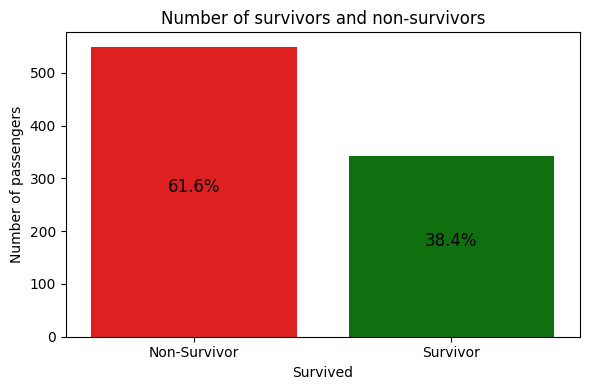

In [18]:
survival_counts = train_df['Survived'].value_counts()
survival_proportion = train_df['Survived'].value_counts(normalize=True)

plt.figure(figsize=(6,4))
sns.barplot(x=survival_counts.index, y=survival_counts.values, palette=['red','green'])
plt.title('Number of survivors and non-survivors')
plt.ylabel('Number of passengers')
plt.xticks([0,1], ['Non-Survivor', 'Survivor'])

for i, value in enumerate(survival_counts.values):
    percentage = survival_proportion[i] * 100
    plt.text(i, value/2, f"{percentage:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

### Survival Rate by Sex

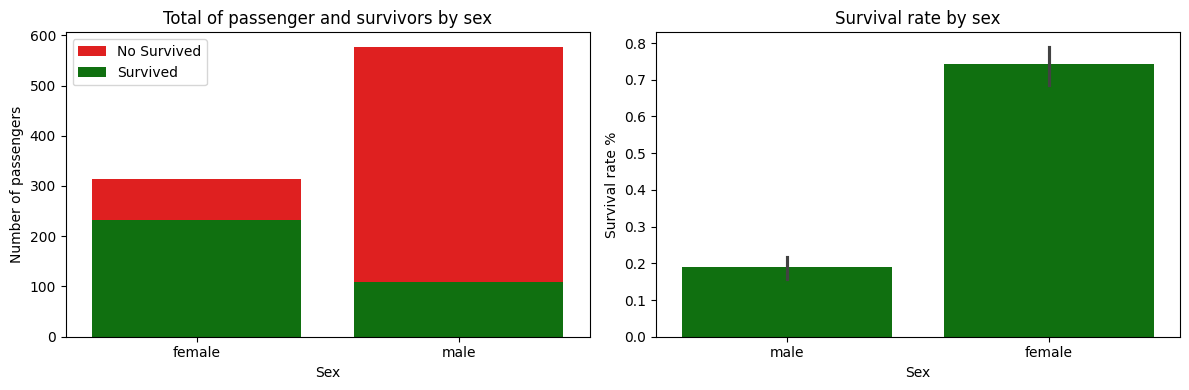

In [19]:
sex_stats = train_df.groupby('Sex')['Survived'].agg(total='count', survived='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=sex_stats.index, y=sex_stats['total'], color='red', label="No Survived", ax=axes[0])
sns.barplot(x=sex_stats.index, y=sex_stats['survived'], color='green', label="Survived", ax=axes[0])
axes[0].set_title('Total of passenger and survivors by sex')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='Sex', y='Survived', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Survival rate by sex')
axes[1].set_ylabel('Survival rate %')

plt.tight_layout()
plt.show()

### Survival Rate by Class

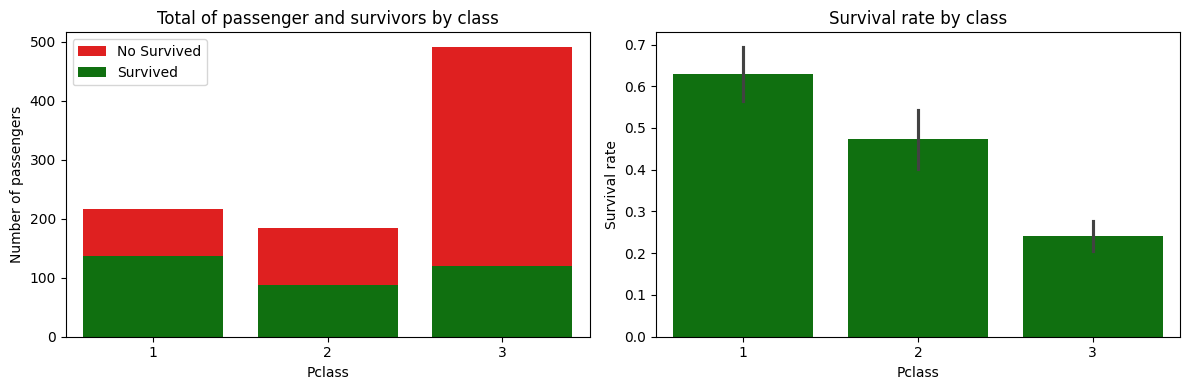

In [20]:
class_stats = train_df.groupby('Pclass')['Survived'].agg(total='count', survived='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=class_stats.index, y=class_stats['total'], color='red', label="No Survived", ax=axes[0])
sns.barplot(x=class_stats.index, y=class_stats['survived'], color='green', label="Survived", ax=axes[0])
axes[0].set_title('Total of passenger and survivors by class')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='Pclass', y='Survived', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Survival rate by class')
axes[1].set_ylabel('Survival rate')

plt.tight_layout()
plt.show()

### Survival Rate by Age

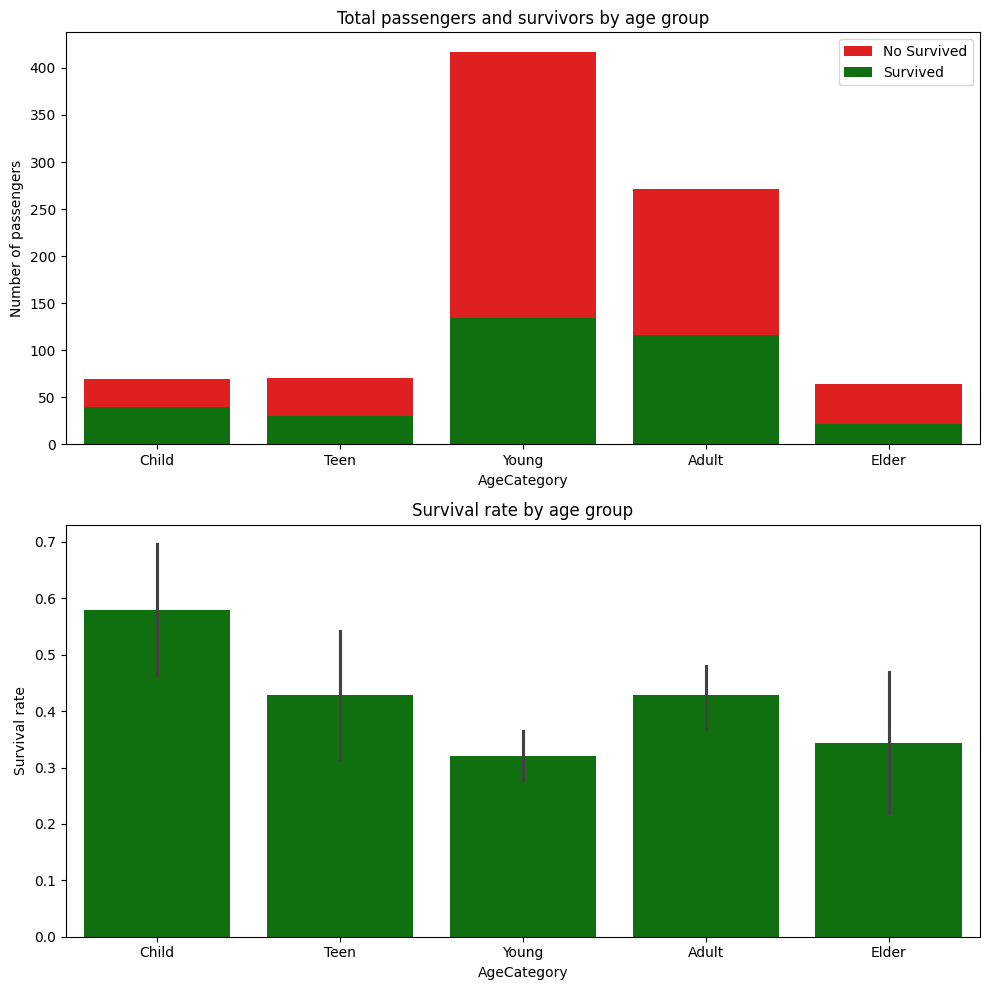

In [21]:
age_stats = train_df.groupby('AgeCategory')['Survived'].agg(total='count', survived='sum')

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.barplot(x=age_stats.index, y=age_stats['total'], color='red', label='No Survived', ax=axes[0])
sns.barplot(x=age_stats.index, y=age_stats['survived'], color='green', label='Survived', ax=axes[0])
axes[0].set_title('Total passengers and survivors by age group')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='AgeCategory', y='Survived', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Survival rate by age group')
axes[1].set_ylabel('Survival rate')

plt.tight_layout()
plt.show()

### Survival Rate by Fare

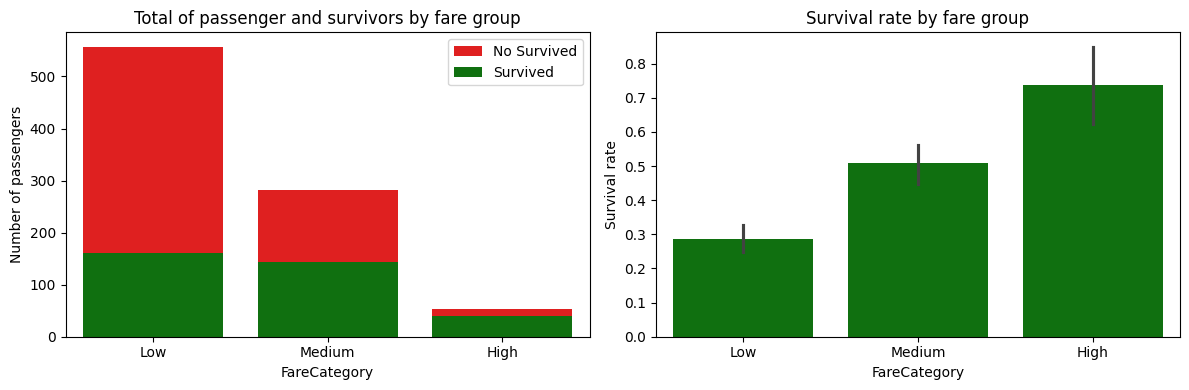

In [22]:
fare_stats = train_df.groupby('FareCategory')['Survived'].agg(total='count', survived='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=fare_stats.index, y=fare_stats['total'], color='red', label='No Survived', ax=axes[0])
sns.barplot(x=fare_stats.index, y=fare_stats['survived'], color='green', label='Survived', ax=axes[0])
axes[0].set_title('Total of passenger and survivors by fare group')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='FareCategory', y='Survived', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Survival rate by fare group')
axes[1].set_ylabel('Survival rate')

plt.tight_layout()
plt.show()

### Survival Rate by Embarked Place

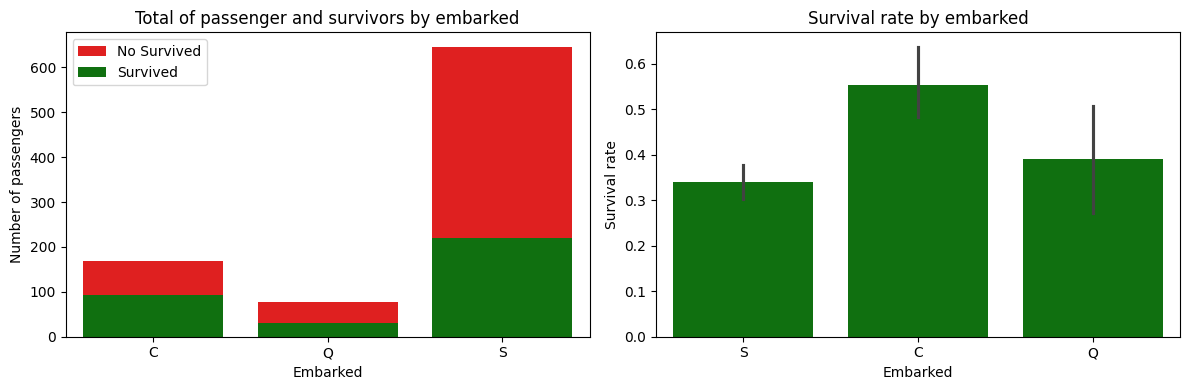

In [23]:
emb_stats = train_df.groupby('Embarked')['Survived'].agg(total='count', survived='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=emb_stats.index, y=emb_stats['total'], color='red', label='No Survived', ax=axes[0])
sns.barplot(x=emb_stats.index, y=emb_stats['survived'], color='green', label='Survived', ax=axes[0])
axes[0].set_title('Total of passenger and survivors by embarked')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='Embarked', y='Survived', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Survival rate by embarked')
axes[1].set_ylabel('Survival rate')

plt.tight_layout()
plt.show()

### Survival Rate by Family Type

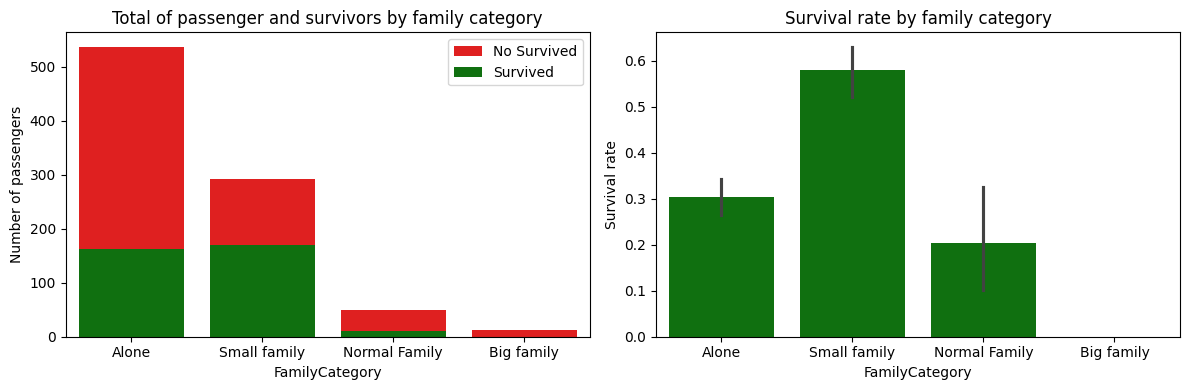

In [24]:
fam_stats = train_df.groupby('FamilyCategory')['Survived'].agg(total='count', survived='sum')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x=fam_stats.index, y=fam_stats['total'], color='red', label='No Survived', ax=axes[0])
sns.barplot(x=fam_stats.index, y=fam_stats['survived'], color='green', label='Survived', ax=axes[0])
axes[0].set_title('Total of passenger and survivors by family category')
axes[0].set_ylabel('Number of passengers')
axes[0].legend()

sns.barplot(x='FamilyCategory', y='Survived', data=train_df, color='green', ax=axes[1])
axes[1].set_title('Survival rate by family category')
axes[1].set_ylabel('Survival rate')

plt.tight_layout()
plt.show()

### Survival Rate by Class and Age

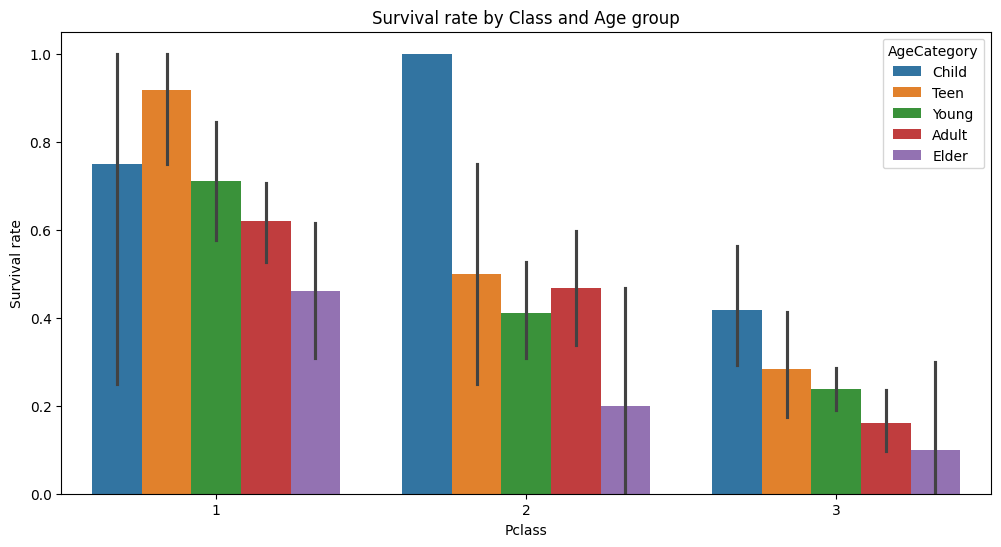

In [25]:
plt.figure(figsize=(12,6))
sns.barplot(x='Pclass', y='Survived', hue='AgeCategory', data=train_df)
plt.title('Survival rate by Class and Age group')
plt.ylabel('Survival rate')
plt.show()

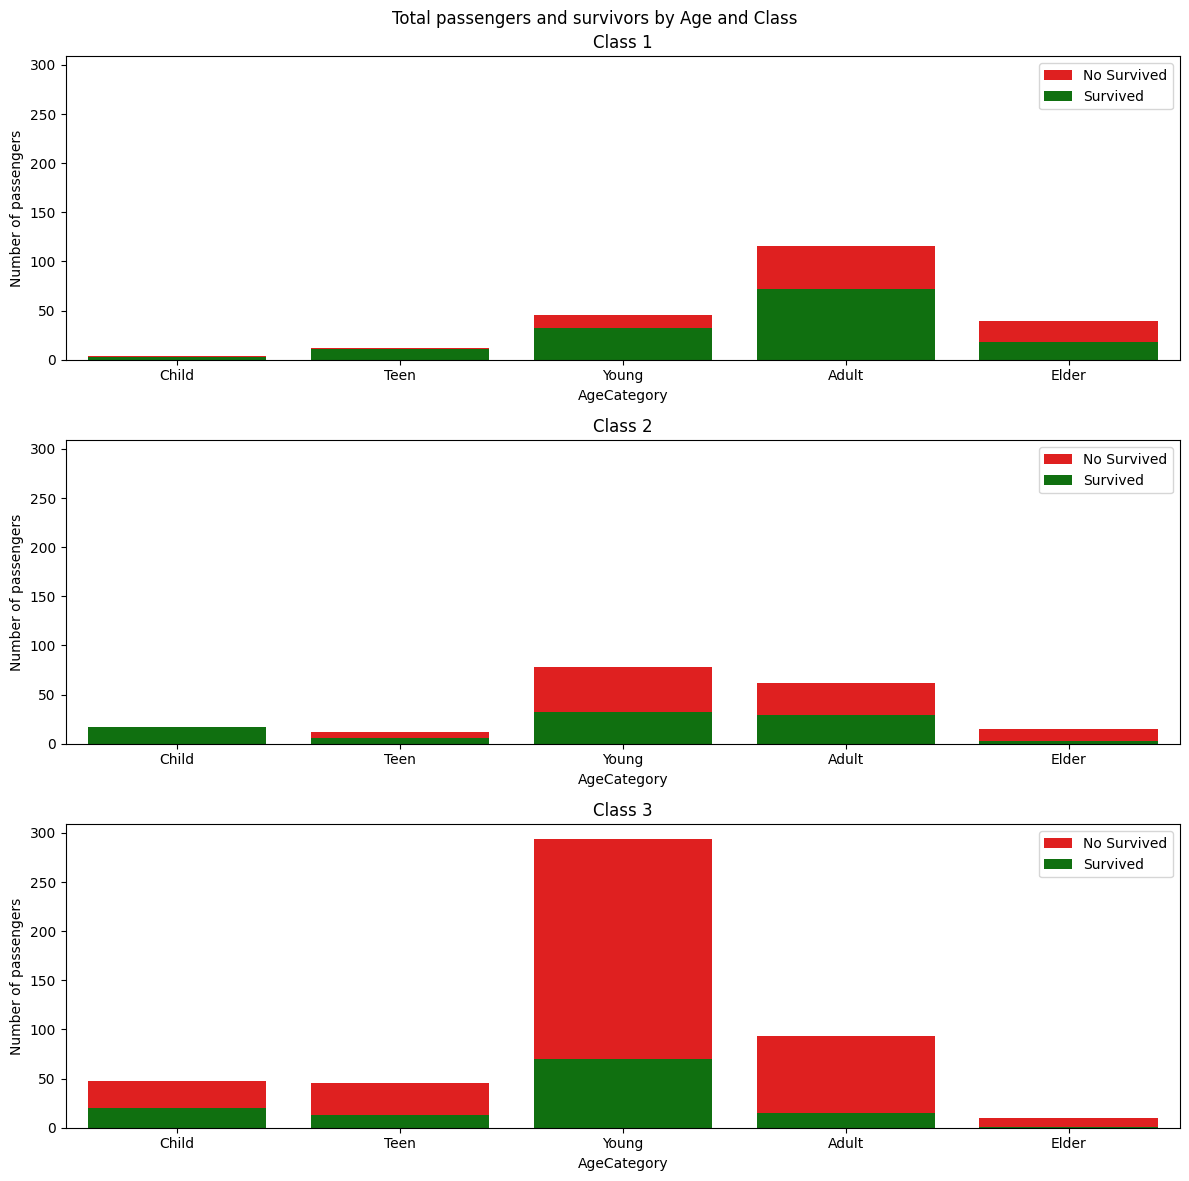

In [26]:
age_class_stats = train_df.groupby(['Pclass','AgeCategory'])['Survived'].agg(total='count', survived='sum').unstack()
fig, axes = plt.subplots(3, 1, figsize=(12,12), sharey=True)

for i, cls in enumerate(age_class_stats.index):
    ax = axes[i]
    survived = age_class_stats.loc[cls]['survived']
    total = age_class_stats.loc[cls]['total']
    
    sns.barplot(x=total.index, y=total, color='red', label="No Survived", ax=ax)
    sns.barplot(x=total.index, y=survived, color='green', label="Survived", ax=ax)
    ax.set_title(f'Class {cls}')
    ax.set_ylabel('Number of passengers')
    ax.legend()

fig.suptitle('Total passengers and survivors by Age and Class')

plt.tight_layout()
plt.show()

### Survival Rate by Sex and Age

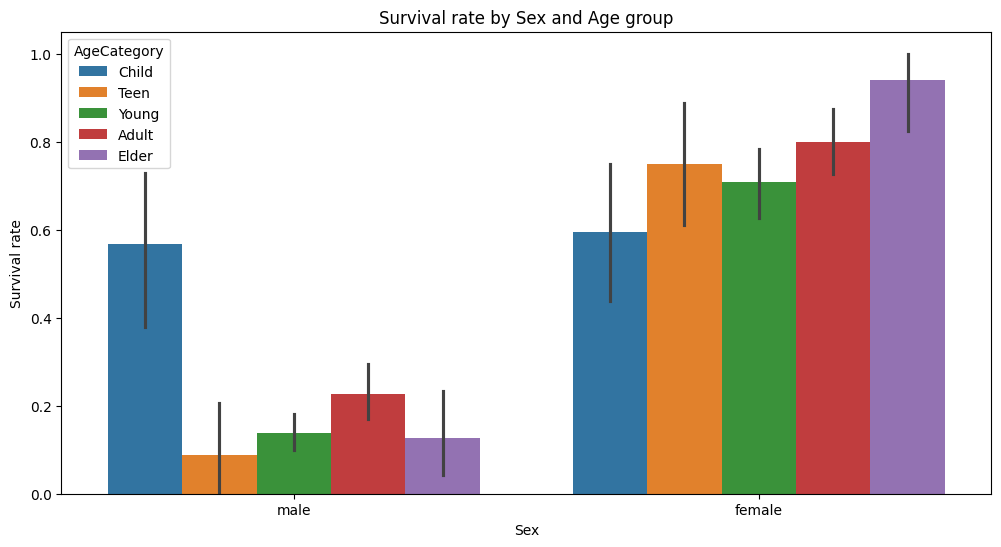

In [27]:
plt.figure(figsize=(12,6))
sns.barplot(x='Sex', y='Survived', hue='AgeCategory', data=train_df)
plt.title('Survival rate by Sex and Age group')
plt.ylabel('Survival rate')
plt.show()

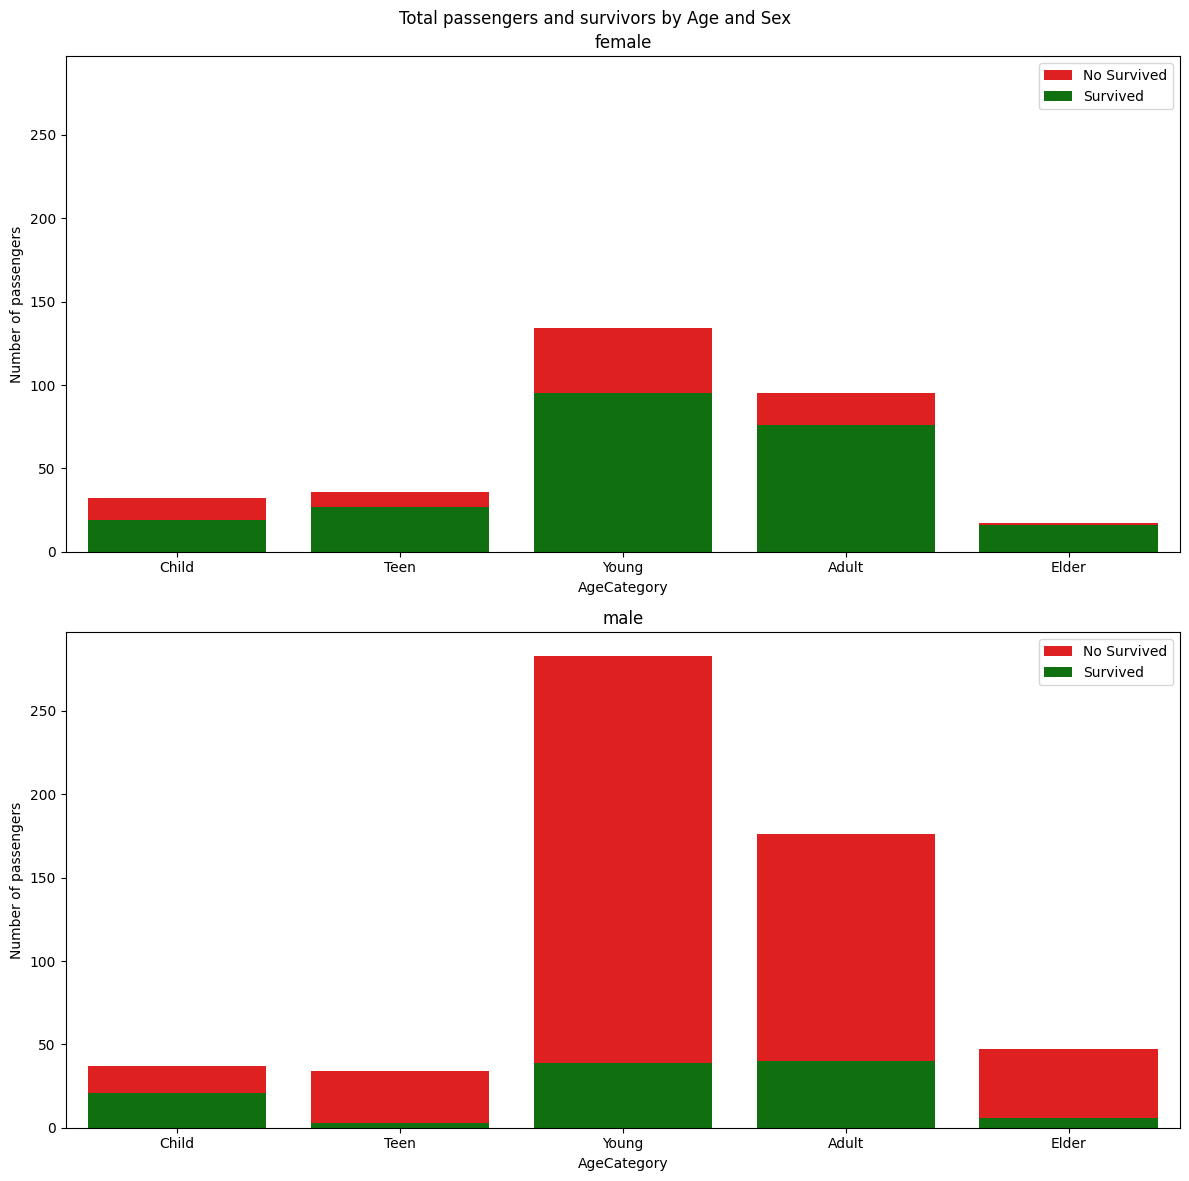

In [28]:
age_sex_stats = train_df.groupby(['Sex','AgeCategory'])['Survived'].agg(total='count', survived='sum').unstack()
fig, axes = plt.subplots(2, 1, figsize=(12,12), sharey=True)

for i, sex in enumerate(age_sex_stats.index):
    ax = axes[i]
    survived = age_sex_stats.loc[sex]['survived']
    total = age_sex_stats.loc[sex]['total']
    
    sns.barplot(x=total.index, y=total, color='red', label="No Survived", ax=ax)
    sns.barplot(x=total.index, y=survived, color='green', label="Survived", ax=ax)
    ax.set_title(sex)
    ax.set_ylabel('Number of passengers')
    ax.legend()

fig.suptitle('Total passengers and survivors by Age and Sex')

plt.tight_layout()
plt.show()

### Survival Rate by Class and Sex

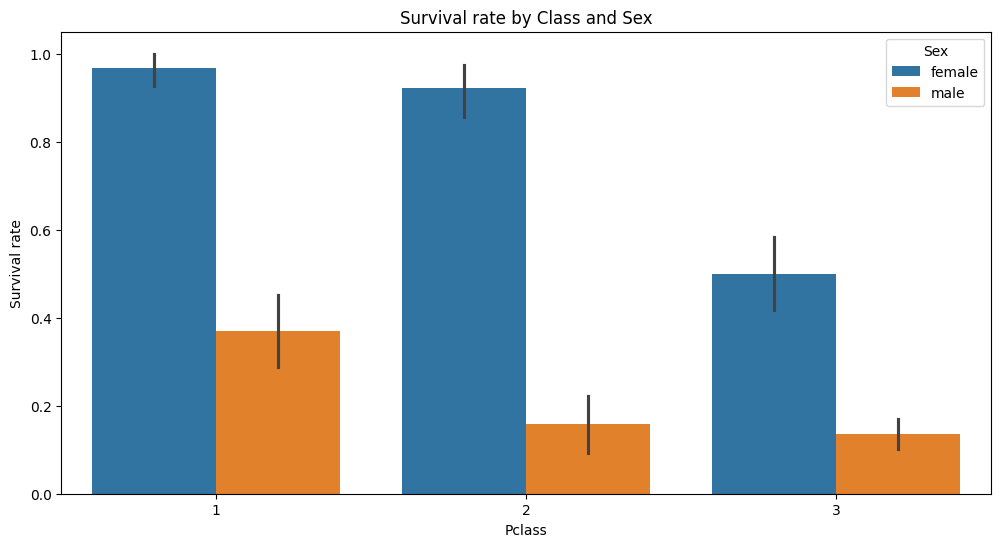

In [29]:
plt.figure(figsize=(12,6))
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train_df)
plt.title('Survival rate by Class and Sex')
plt.ylabel('Survival rate')
plt.show()

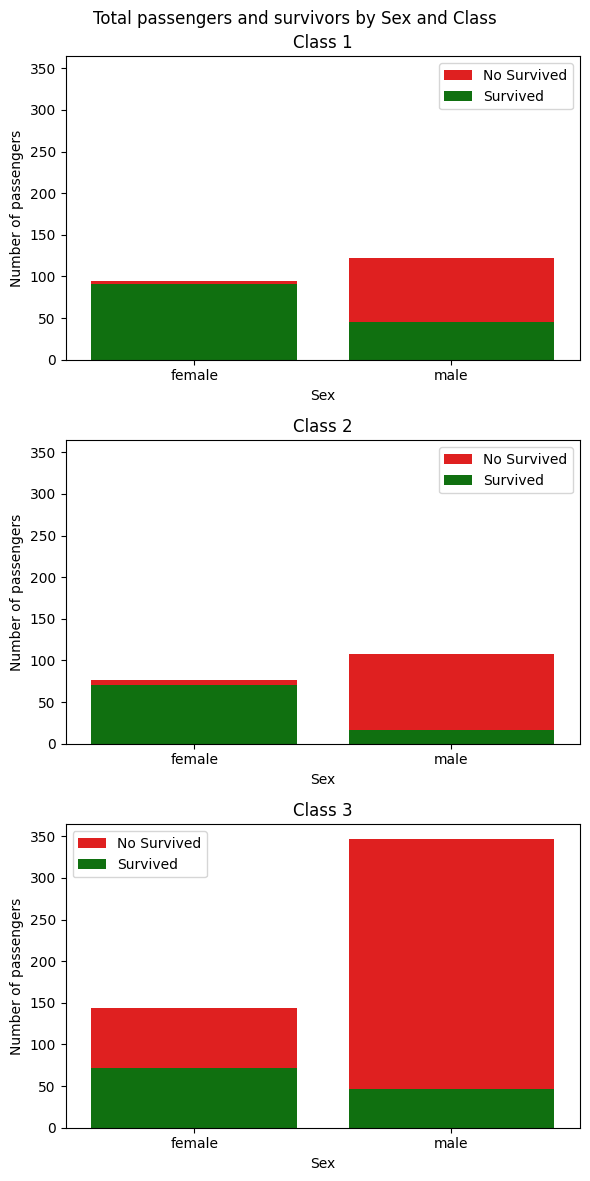

In [30]:
sex_class_stats = train_df.groupby(['Pclass','Sex'])['Survived'].agg(total='count', survived='sum').unstack()
fig, axes = plt.subplots(3, 1, figsize=(6,12), sharey=True)

for i, cls in enumerate(sex_class_stats.index):
    ax = axes[i]
    survived = sex_class_stats.loc[cls]['survived']
    total = sex_class_stats.loc[cls]['total']
    
    sns.barplot(x=total.index, y=total, color='red', label="No Survived", ax=ax)
    sns.barplot(x=total.index, y=survived, color='green', label="Survived", ax=ax)
    ax.set_title(f'Class {cls}')
    ax.set_ylabel('Number of passengers')
    ax.legend()

fig.suptitle('Total passengers and survivors by Sex and Class')

plt.tight_layout()
plt.show()

After the exploratory data analysis and with the visual aid of graphs showing survival rates across different features, we can identify which variables had a positive or negative impact on the probability of surviving the Titanic disaster.

With this preliminary information, the next step is to clean the dataset by converting all categorical variables into numerical values to facilitate further analysis. Then, we will perform a correlation study to examine how the different variables relate to the target variable 'Survived'.

This analysis will help us determine which variables are most relevant and which contribute less information, allowing us to select the most significant ones for training the predictive models.

### Data Cleaning and Correlation

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Survived        891 non-null    int64   
 1   Pclass          891 non-null    int64   
 2   Sex             891 non-null    object  
 3   Age             891 non-null    float64 
 4   Fare            891 non-null    float64 
 5   Embarked        891 non-null    object  
 6   Title           891 non-null    object  
 7   SexClass        891 non-null    object  
 8   AgeCategory     891 non-null    category
 9   TicketLett      891 non-null    object  
 10  TicketLen       891 non-null    int64   
 11  TicketNum       891 non-null    Int64   
 12  GroupSize       891 non-null    Int64   
 13  TicketType      891 non-null    object  
 14  PerPersonFare   891 non-null    float64 
 15  FareCategory    891 non-null    category
 16  FamilySize      891 non-null    int64   
 17  FamilyCategory  

In [32]:
category_mappings = {}

categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    all_categories = pd.Categorical(pd.concat([train_df[col], test_df[col]], axis=0)).categories

    train_df[col] = pd.Categorical(train_df[col], categories=all_categories)
    test_df[col] = pd.Categorical(test_df[col], categories=all_categories)
    
    # Saving the int value for each category in a map
    category_mappings[col] = dict(enumerate(train_df[col].cat.categories))
    
    # Categorical to int
    train_df[col] = train_df[col].cat.codes
    test_df[col] = test_df[col].cat.codes

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Survived        891 non-null    int64  
 1   Pclass          891 non-null    int64  
 2   Sex             891 non-null    int8   
 3   Age             891 non-null    float64
 4   Fare            891 non-null    float64
 5   Embarked        891 non-null    int8   
 6   Title           891 non-null    int8   
 7   SexClass        891 non-null    int8   
 8   AgeCategory     891 non-null    int8   
 9   TicketLett      891 non-null    int8   
 10  TicketLen       891 non-null    int64  
 11  TicketNum       891 non-null    Int64  
 12  GroupSize       891 non-null    Int64  
 13  TicketType      891 non-null    int8   
 14  PerPersonFare   891 non-null    float64
 15  FareCategory    891 non-null    int8   
 16  FamilySize      891 non-null    int64  
 17  FamilyCategory  891 non-null    int

In [34]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,SexClass,AgeCategory,TicketLett,...,TicketType,PerPersonFare,FareCategory,FamilySize,FamilyCategory,IsAlone,WithSpouse,WithChildren,WithParents,CabinLetter
0,0,3,1,22.0,7.2500,2,3,5,2,39,...,1,7.2500,0,2,1,0,1,0,0,5
1,1,1,0,38.0,71.2833,0,4,0,3,50,...,1,71.2833,1,2,1,0,1,0,0,2
2,1,3,0,26.0,7.9250,2,2,2,2,55,...,1,7.9250,0,1,0,1,0,0,0,5
3,1,1,0,35.0,53.1000,2,4,0,3,0,...,0,26.5500,1,2,1,0,1,0,0,2
4,0,3,1,35.0,8.0500,2,3,5,3,23,...,1,8.0500,0,1,0,1,0,0,0,5


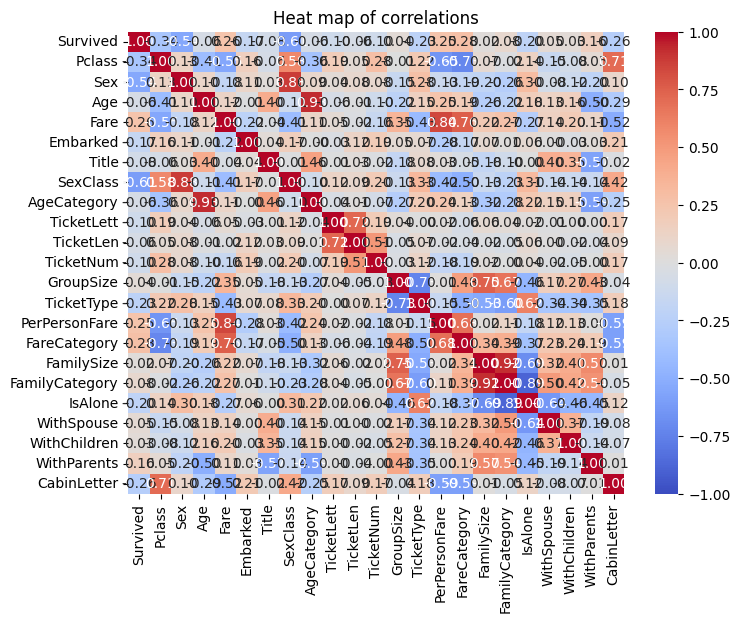

In [35]:
corr_matrix = train_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Heat map of correlations")
plt.show()

# Model Development and Training

After the previous sections, where we analyzed the dataset, created new features, and gained valuable insights from the exploratory data analysis, we can now move forward to the model development phase.

In this stage, we first prepare the datasets for training by applying preprocessing techniques such as One-Hot Encoding (OHE) and feature selection, which help the models learn more efficiently and improve their generalization performance.

We will then experiment with a wide variety of algorithms — from linear models to tree-based and ensemble methods, as well as neural networks and boosting frameworks, among others — to evaluate which approaches best fit this prediction problem. The goal is to perform a comprehensive comparison across different model families and determine which ones capture the underlying patterns of the Titanic dataset most effectively.

In [36]:
# Making a clean df for the training with less features
train_clean_df = train_df.copy()
test_clean_df = test_df.copy()

delete_columns = ['Sex', 'SexClass', 'Fare', 'AgeCategory', 'FareCategory', 'GroupSize', 'FamilySize', 'Age', 'CabinLetter', 'TicketType', 'TicketNum', 'IsAlone', 'WithSpouse', 'WithChildren', 'WithParents']

train_clean_df = train_clean_df.drop(columns=delete_columns)
test_clean_df = test_clean_df.drop(columns=delete_columns)

train_clean_df.head()

,Survived,Pclass,Embarked,Title,TicketLett,TicketLen,PerPersonFare,FamilyCategory
0,0,3,2,3,39,9,7.2500,1
1,1,1,0,4,50,8,71.2833,1
2,1,3,2,2,55,16,7.9250,0
3,1,1,2,4,0,6,26.5500,1
4,0,3,2,3,23,6,8.0500,0


In [37]:
# One-hot encoding all non-ordinal categorical variables 
categorical_columns = ['Pclass', 'Title', 'Embarked', 'FamilyCategory', 'TicketLett', 'TicketLen', 'SexClass', 'AgeCategory', 'TicketNum', 'TicketType', 'FareCategory', 'CabinLetter']
ohe_columns = [col for col in categorical_columns if col not in delete_columns]
print(ohe_columns)

train_clean_df = pd.get_dummies(train_clean_df, columns=ohe_columns, dtype=int)
test_clean_df = pd.get_dummies(test_clean_df, columns=ohe_columns, dtype=int)

train_target = train_clean_df['Survived']
test_id = test_clean_df['PassengerId']

train_clean_df = train_clean_df.drop(columns=['Survived'])
test_clean_df = test_clean_df.drop(columns=['PassengerId'])

# Align variables between train and test
train_clean_df, test_clean_df = train_clean_df.align(test_clean_df, join='left', axis=1, fill_value=0)

train_clean_df.insert(0, 'Survived', train_target)
test_clean_df.insert(0, 'PassengerId', test_id)

['Pclass', 'Title', 'Embarked', 'FamilyCategory', 'TicketLett', 'TicketLen']


In [38]:
# Preparing the sets for train and test
X_train = train_clean_df.drop("Survived", axis=1)
Y_train = train_clean_df["Survived"]
X_test  = test_clean_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 87), (891,), (418, 87))

In [39]:
# Making a reduced DF to keep only the most influential variables according to RF (Not Used)
rf = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=4, n_jobs=-1, max_features='sqrt')

rf.fit(X_train, Y_train)

selector = SelectFromModel(rf, prefit=True, threshold="median")
selected_features = X_train.columns[selector.get_support()]

X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

print("Selected features:", list(selected_features))

Selected features: ['PerPersonFare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_1', 'Title_2', 'Title_3', 'Title_4', 'Embarked_0', 'Embarked_1', 'Embarked_2', 'FamilyCategory_0', 'FamilyCategory_1', 'FamilyCategory_2', 'FamilyCategory_3', 'TicketLett_0', 'TicketLett_2', 'TicketLett_3', 'TicketLett_4', 'TicketLett_5', 'TicketLett_6', 'TicketLett_11', 'TicketLett_13', 'TicketLett_15', 'TicketLett_16', 'TicketLett_17', 'TicketLett_19', 'TicketLett_20', 'TicketLett_21', 'TicketLett_24', 'TicketLett_26', 'TicketLett_39', 'TicketLett_44', 'TicketLett_50', 'TicketLett_52', 'TicketLett_55', 'TicketLett_57', 'TicketLen_4', 'TicketLen_5', 'TicketLen_6', 'TicketLen_7', 'TicketLen_8', 'TicketLen_9', 'TicketLen_17']


In [40]:
models_df = pd.DataFrame(columns=['Model', 'Accuracy_Mean', 'Accuracy_Std'])

## Logistic Regression

In [41]:
# Standarization + Logistic Regression

log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(penalty='l2', C=10, solver='lbfgs', max_iter=1000, tol=1e-3))])

scores = cross_val_score(log_reg_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Logistic Regression', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8137 ± 0.0204


In [42]:
log_reg_pipeline.fit(X_train, Y_train)
coeff_df = pd.DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(log_reg_pipeline.named_steps['log_reg'].coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
8,Embarked_0,0.586257
6,Title_3,0.577399
5,Title_2,0.484037
20,TicketLett_5,0.378087
68,TicketLett_57,0.368378
...,...,...
69,TicketLett_58,-0.309139
78,TicketLen_10,-0.357923
14,FamilyCategory_3,-0.453401
15,TicketLett_0,-0.906355


## Naive Bayes

In [43]:
# Naive Bayes

nb_model = GaussianNB()

scores = cross_val_score(nb_model, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Naive Bayes', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.4613 ± 0.0046


## Perceptron

In [44]:
# Standarization + Perceptron

perceptron_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('perceptron', Perceptron(max_iter=1000, tol=1e-3))])

scores = cross_val_score(perceptron_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Perceptron', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.7586 ± 0.0371


## SGD

In [45]:
# Standarization + SGD

sgd_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDClassifier(loss='log_loss', penalty='l2', alpha=0.01, 
                          max_iter=1000, tol=1e-3))])

scores = cross_val_score(sgd_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['SGD', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8159 ± 0.0204


## SVM

In [46]:
# Standarization + SVM

svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=0.5, kernel='rbf', gamma='scale', max_iter=1000, tol=1e-3, probability=True))])

scores = cross_val_score(svc_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['SVM', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.7968 ± 0.0224


## Linear SVM

In [47]:
# Standarization + Linear SVM

linear_svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC(C=1, penalty='l2', loss='squared_hinge', 
                      max_iter=10000, tol=1e-3))])

scores = cross_val_score(linear_svc_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Linear SVM', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8204 ± 0.0258


## KNN

In [48]:
# Standarization + KNN

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=10, weights='distance', 
                                 metric='minkowski', p=2))])

scores = cross_val_score(knn_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['KNN', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.7587 ± 0.0359


## Decision Tree

In [49]:
# Decision Tree

tree_model = DecisionTreeClassifier(criterion='gini', max_depth=6, 
                                    min_samples_split=2, min_samples_leaf=1)

scores = cross_val_score(tree_model, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Decision Tree', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8204 ± 0.0181


## Random Forest

In [50]:
# Running a GridSearch to find the best hyperparameters set for the model
param_grid = {
    'n_estimators': [250, 500, 1000],
    'max_depth': [4, 6, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

grid_rf.fit(X_train, Y_train)

print("Best parameters:", grid_rf.best_params_)
print("Best CV accuracy:", grid_rf.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 250}
Best CV accuracy: 0.832772581758835


In [51]:
# Random Forest

rf_model = RandomForestClassifier(n_estimators=250, criterion='gini', max_depth=4, min_samples_leaf=1, min_samples_split=2,
                                  bootstrap=False, n_jobs=-1, max_features='sqrt')

scores = cross_val_score(rf_model, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Random Forest', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8160 ± 0.0254


## Gradient Boosting

In [52]:
# Gradient Boosting

gb_model = GradientBoostingClassifier(n_estimators=250, learning_rate=0.1, max_depth=4, 
                                      min_samples_split=2, min_samples_leaf=1, subsample=1)

scores = cross_val_score(gb_model, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Gradient Boosting', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8126 ± 0.0249


## XGBoost

In [53]:
# XGBoost

xgb_model = xgb.XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=4, 
                              subsample=0.8, colsample_bytree=0.8, objective='binary:logistic', eval_metric='logloss')

scores = cross_val_score(xgb_model, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['XGBoost', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8114 ± 0.0342


## LightGBM

In [54]:
# LightGBM

lgb_model = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, max_depth=4, num_leaves=7,
                               subsample=0.8, bagging_fraction=0.8, feature_fraction=1, bagging_freq=1, 
                               objective='binary', metric='binary_logloss', boosting_type='gbdt',
                               verbose=-1)

scores = cross_val_score(lgb_model, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['LightGBM', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8193 ± 0.0173


## MLP

In [55]:
# Standarization + MLP

mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(50,20), activation='relu', solver='adam', 
                          learning_rate_init=0.001, max_iter=5000, tol=1e-4))])

scores = cross_val_score(mlp_pipeline, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['MLP', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.7946 ± 0.0222


### Model accuracy analysis

In [56]:
# Sorting models by accuracy
models_df.sort_values(by='Accuracy_Mean', ascending=False)

,Model,Accuracy_Mean,Accuracy_Std
7,Decision Tree,0.820426,0.018122
5,Linear SVM,0.820394,0.025809
11,LightGBM,0.819296,0.017268
8,Random Forest,0.815975,0.025391
3,SGD,0.815912,0.020419
0,Logistic Regression,0.813665,0.020439
9,Gradient Boosting,0.812554,0.024879
10,XGBoost,0.811443,0.034214
4,SVM,0.796849,0.022373
12,MLP,0.794602,0.022169


## Stacking

In [57]:
# Stacking

# Base Models - RF, SVM, XGBoost
estimators = [('rf', rf_model),
             ('svm', svc_pipeline),
             ('xgb', xgb_model)]

# Meta-Learner
meta_learner = LogisticRegression(max_iter=2500)

stack_model = StackingClassifier(estimators=estimators, final_estimator=meta_learner,
                                 cv=5, n_jobs=-1, passthrough=False, stack_method='predict_proba')

scores = cross_val_score(stack_model, X_train, Y_train, cv=5, scoring='accuracy')
models_df.loc[len(models_df)] = ['Stacking', scores.mean(), scores.std()]

print(f"Accuracy media (CV=5): {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy media (CV=5): 0.8238 ± 0.0198


In [58]:
# Sorting models by accuracy with Stacking
models_df.sort_values(by='Accuracy_Mean', ascending=False)

,Model,Accuracy_Mean,Accuracy_Std
13,Stacking,0.823809,0.019821
7,Decision Tree,0.820426,0.018122
5,Linear SVM,0.820394,0.025809
11,LightGBM,0.819296,0.017268
8,Random Forest,0.815975,0.025391
3,SGD,0.815912,0.020419
0,Logistic Regression,0.813665,0.020439
9,Gradient Boosting,0.812554,0.024879
10,XGBoost,0.811443,0.034214
4,SVM,0.796849,0.022373


## Training and Prediction

Based on the cross-validation results obtained, we select the best-performing models, ensuring a balance between accuracy and model diversity.

These selected models are then trained on the full training dataset and used to generate predictions on the test set. The resulting output is saved as a CSV file, which will be submitted to the Kaggle competition to evaluate the final score and compare the performance of our approach against other participants.

In [59]:
stack_model.fit(X_train, Y_train)

y_test_pred = stack_model.predict(X_test)

submission_stack = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_pred})

submission_stack.to_csv('submission_stack.csv', index=False)

In [60]:
rf_model.fit(X_train, Y_train)

y_test_pred = rf_model.predict(X_test)

submission_rf = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_pred})

submission_rf.to_csv('submission_rf.csv', index=False)

In [61]:
svc_pipeline.fit(X_train, Y_train)

y_test_pred = svc_pipeline.predict(X_test)

submission_svc = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_pred})

submission_svc.to_csv('submission_svc.csv', index=False)

In [62]:
xgb_model.fit(X_train, Y_train)

y_test_pred = xgb_model.predict(X_test)

submission_xgb = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_pred})

submission_xgb.to_csv('submission_xgb.csv', index=False)

In [63]:
lgb_model.fit(X_train, Y_train)

y_test_pred = lgb_model.predict(X_test)

submission_lgb = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_pred})

submission_lgb.to_csv('submission_lgb.csv', index=False)

In [64]:
mlp_pipeline.fit(X_train, Y_train)

y_test_pred = mlp_pipeline.predict(X_test)

submission_mlp = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_pred})

submission_mlp.to_csv('submission_mlp.csv', index=False)

# Conclusions and Insights

Although the Titanic dataset may seem like a simple problem at first glance, it actually has significant depth. With careful exploration, a wide range of insights can be extracted from the data. However, one of the main challenges lies in the limited size of the dataset — the small number of samples makes it difficult for many models to generalize or learn meaningful patterns that lead to strong predictive performance.

Another complicating factor is the class imbalance, since over 60% of passengers did not survive. This means that any model achieving an accuracy close to that percentage is essentially performing at a near-random level.

After extensive experimentation and tuning, I managed to find several combinations of features that complemented each other well enough for the models to achieve an average accuracy above 75%, with Random Forest standing out as the best-performing algorithm, reaching over 81% accuracy. This result placed the submission within the top 2% of the Kaggle leaderboard — a very solid outcome given the dataset’s limitations.

I’m confident that the performance could still be improved, potentially reaching 85% or higher, by identifying better feature combinations or engineering new variables that capture additional information. Moreover, exploring more advanced models could also yield further improvements. Despite the simplicity of the dataset, this challenge provides an excellent opportunity to practice end-to-end machine learning workflows and gain deeper insight into the power — and limits — of data-driven modeling.